# Learning Curves

In [1]:
# remove after testing
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from mclearn.classifier import (train_classifier,
                                grid_search_logistic,
                                grid_search_svm_poly,
                                grid_search_svm_rbf,
                                learning_curve)
from mclearn.preprocessing import balanced_train_test_split
from mclearn.tools import results_exist, load_results
from mclearn.viz import plot_learning_curve, plot_average_learning_curve, plot_validation_accuracy_heatmap
%matplotlib inline
sns.set_style('ticks')

In [3]:
fig_dir = '../thesis/figures/'
target_col = 'class'
sdss_features = ['psfMag_r_w14', 'psf_u_g_w14', 'psf_g_r_w14', 'psf_r_i_w14',
                'psf_i_z_w14', 'petroMag_r_w14', 'petro_u_g_w14', 'petro_g_r_w14',
                'petro_r_i_w14', 'petro_i_z_w14', 'petroRad_r']
vstatlas_features = ['rmagC', 'umg', 'gmr', 'rmi', 'imz', 'rmw1', 'w1m2']

In [4]:
sdss = pd.read_hdf('../data/sdss.h5', 'sdss')
vstatlas = pd.read_hdf('../data/vstatlas.h5', 'vstatlas')

X_sdss, _, y_sdss, _ = balanced_train_test_split(
    sdss[sdss_features], sdss[target_col], train_size=10000, test_size=0, random_state=2)
X_vstatlas, _, y_vstatlas, _ = balanced_train_test_split(
    vstatlas[vstatlas_features], vstatlas[target_col], train_size=2360, test_size=0, random_state=2)

## Hyperparameter Optimization

We start by optimising the hyperparameters with grid search. For each combination, we use a 5-fold cross validation, each fold having 300 examples in the training set and 300 in the test set.

In [4]:
sdss_rbf_path = '../pickle/04_learning_curves/sdss_rbf_scores.pickle'
sdss_rbf_heat = fig_dir + '4_expt1/sdss_grid_rbf.pdf'
sdss_poly_path = '../pickle/04_learning_curves/sdss_poly_scores.pickle'
sdss_poly_heat = fig_dir + '4_expt1/sdss_grid_poly.pdf'
sdss_logistic_path = '../pickle/04_learning_curves/sdss_logistic_scores.pickle'
sdss_logistic_heat = fig_dir + '4_expt1/sdss_grid_logistic.pdf'
sdss_paths = [sdss_rbf_path, sdss_poly_path, sdss_logistic_path]

vstatlas_rbf_path = '../pickle/04_learning_curves/vstatlas_rbf_scores.pickle'
vstatlas_rbf_heat = fig_dir + '4_expt1/vstatlas_grid_rbf.pdf'
vstatlas_poly_path = '../pickle/04_learning_curves/vstatlas_poly_scores.pickle'
vstatlas_poly_heat = fig_dir + '4_expt1/vstatlas_grid_poly.pdf'
vstatlas_logistic_path = '../pickle/04_learning_curves/vstatlas_logistic_scores.pickle'
vstatlas_logistic_heat = fig_dir + '4_expt1/vstatlas_grid_logistic.pdf'
vstatlas_paths = [vstatlas_rbf_path, vstatlas_poly_path, vstatlas_logistic_path]

logistic_labels = ['Degree 1, OVR, L1-norm',
                   'Degree 1, OVR, L2-norm',
                   'Degree 1, Multinomial, L2-norm',
                   'Degree 2, OVR, L1-norm',
                   'Degree 2, OVR, L2-norm',
                   'Degree 2, Multinomial, L2-norm',
                   'Degree 3, OVR, L1-norm',
                   'Degree 3, OVR, L2-norm',
                   'Degree 3, Multinomial, L2-norm']

poly_labels = ['Degree 1, OVR, Squared Hinge, L1-norm',
               'Degree 1, OVR, Squared Hinge, L2-norm',
               'Degree 1, OVR, Hinge, L2-norm',
               'Degree 1, Crammer-Singer',
               'Degree 2, OVR, Squared Hinge, L1-norm',
               'Degree 2, OVR, Squared Hinge, L2-norm',
               'Degree 2, OVR, Hinge, L2-norm',
               'Degree 2, Crammer-Singer',
               'Degree 3, OVR, Squared Hinge, L1-norm',
               'Degree 3, OVR, Squared Hinge, L2-norm',
               'Degree 3, OVR, Hinge, L2-norm',
               'Degree 3, Crammer-Singer']

C_rbf_range = np.logspace(-2, 10, 13)
C_range = np.logspace(-6, 6, 13)
gamma_range = np.logspace(-9, 3, 13)

In [5]:
if not results_exist(sdss_rbf_path):
    grid_search_svm_rbf(X_sdss, y_sdss, pickle_path=sdss_rbf_path)
if not results_exist(sdss_poly_path):
    grid_search_svm_poly(X_sdss, y_sdss, pickle_path=sdss_poly_path)
if not results_exist(sdss_logistic_path):
    grid_search_logistic(X_sdss, y_sdss, pickle_path=sdss_logistic_path)

sdss_rbf, sdss_poly, sdss_logistic = load_results(sdss_paths)

In [6]:
if not results_exist(vstatlas_rbf_path):
    grid_search_svm_rbf(X_vstatlas, y_vstatlas, pickle_path=vstatlas_rbf_path)
if not results_exist(vstatlas_poly_path):
    grid_search_svm_poly(X_vstatlas, y_vstatlas, pickle_path=vstatlas_poly_path)
if not results_exist(vstatlas_logistic_path):
    grid_search_logistic(X_vstatlas, y_vstatlas, pickle_path=vstatlas_logistic_path)
    
vstatlas_rbf, vstatlas_poly, vstatlas_logistic = load_results(vstatlas_paths)

### Logistic Regression

The best parameters for the SDSS Dataset are `{degree=3, multi_class='ovr', penalty='l2', C=0.01}`. But this is too slow. We can only do degree 2. The best one here is `{degree=2, multi_class='ovr', penalty='l1', C=1}`.

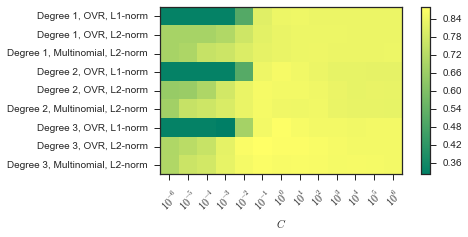

In [10]:
fig = plt.figure(figsize=(7, 3))
im = plot_validation_accuracy_heatmap(sdss_logistic, x_range=C_range, x_label='$C$', power10='x')
plt.yticks(np.arange(0, 9), logistic_labels)
plt.tick_params(top='off', right='off')
plt.colorbar(im)
fig.savefig(sdss_logistic_heat, bbox_inches='tight')

Multinomial has the highest score, but it doesn't give us reliable probability estimates. The next best option for VST ATLAS is `{degree=2, multi_class='ovr', penalty='l1', C=100}`.

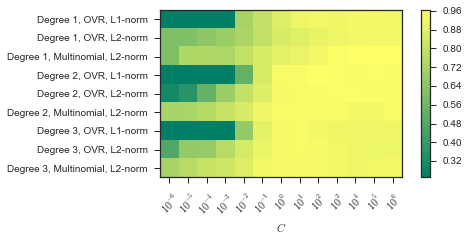

In [10]:
fig = plt.figure(figsize=(7, 3))
im = plot_validation_accuracy_heatmap(vstatlas_logistic, x_range=C_range, x_label='$C$', power10='x')
plt.yticks(np.arange(0, 9), logistic_labels)
plt.tick_params(top='off', right='off')
plt.colorbar(im)
fig.savefig(vstatlas_logistic_heat, bbox_inches='tight')

### SVM with Polynomial Kernel

The best parameters for the SDSS dataset are `{degree=2, multi_class='ovr', loss='squared_hinge', penalty='l1', C=0.1}`:

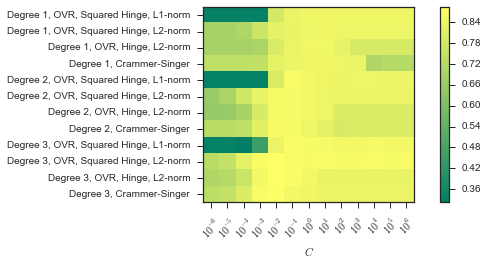

In [7]:
fig = plt.figure(figsize=(9, 3.5))
im = plot_validation_accuracy_heatmap(sdss_poly, x_range=C_range, x_label='$C$', power10='x')
plt.yticks(np.arange(0, 12), poly_labels)
plt.tick_params(top='off', right='off')
plt.colorbar(im)
fig.savefig(sdss_poly_heat, bbox_inches='tight')

The best parameters for the VST ATLAS dataset are `{degree=1, multi_class='crammer-singer', C=1000}`:

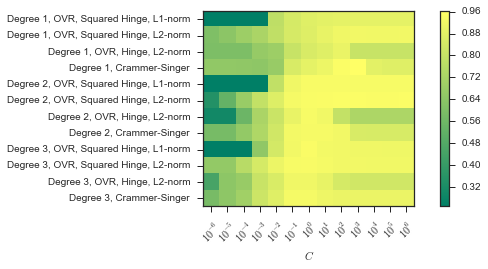

In [8]:
fig = plt.figure(figsize=(9, 3.5))
im = plot_validation_accuracy_heatmap(vstatlas_poly, x_range=C_range, x_label='$C$', power10='x')
plt.yticks(np.arange(0, 12), poly_labels)
plt.tick_params(top='off', right='off')
plt.colorbar(im)
fig.savefig(vstatlas_poly_heat, bbox_inches='tight')

### SVM with RBF Kernel

The best one is `{C = 10,000, gamma=0.001}`.

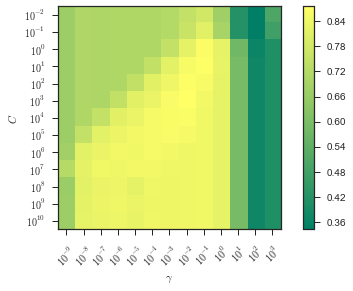

In [15]:
fig = plt.figure(figsize=(8, 4))
im = plot_validation_accuracy_heatmap(sdss_rbf, x_range=gamma_range,
    y_range=C_rbf_range, y_label='$C$', x_label='$\gamma$', power10='both')
plt.tick_params(top='off', right='off')
plt.colorbar(im)
fig.savefig(sdss_rbf_heat, bbox_inches='tight')

The best one is `{C = 1,000,000, gamma=0.001}`.

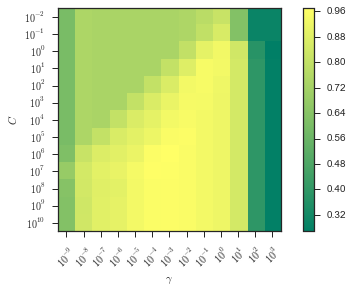

In [16]:
fig = plt.figure(figsize=(8, 4))
im = plot_validation_accuracy_heatmap(vstatlas_rbf, x_range=gamma_range,
    y_range=C_rbf_range, y_label='$C$', x_label='$\gamma$', power10='both')
plt.tick_params(top='off', right='off')
plt.colorbar(im)
fig.savefig(vstatlas_rbf_heat, bbox_inches='tight')

## Learning Curves

### SDSS Learning Curves

Note that logistic regression with degree 3 polynomial transformation takes too long, so we skip obtaining its learning curves.

In [24]:
X = np.asarray(sdss[sdss_features])
y = np.asarray(sdss[target_col])
cv = StratifiedShuffleSplit(y, n_iter=5, test_size=200000, train_size=300001, random_state=29)

In [4]:
rbf = SVC(kernel='rbf', gamma=0.1, C=10, cache_size=2000, class_weight='auto')
poly = LinearSVC(C=0.1, loss='squared_hinge', penalty='l1', dual=False, multi_class='ovr',
                     fit_intercept=True, class_weight='auto', random_state=21)
logistic = LogisticRegression(penalty='l1', dual=False, C=1, multi_class='ovr', solver='liblinear', class_weight='auto', random_state=21)
forest = RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='subsample', random_state=21)
classifiers = [forest, logistic, rbf, poly, poly]
degrees = [1, 2, 1, 2, 3]

In [5]:
sample_sizes = np.concatenate((np.arange(100, 1000, 100), np.arange(1000, 10000, 1000),
                               np.arange(10000, 100001, 10000), [200000, 300000]))
curve_labels = ['Random Forest', 'Logistic Regression', 'RBF SVM', 'Degree 2 Polynomial SVM', 'Degree 3 Polynomial SVM']
pickle_paths = ['../pickle/04_learning_curves/sdss_lc_forest.pickle',
                '../pickle/04_learning_curves/sdss_lc_logistic_2.pickle',
                '../pickle/04_learning_curves/sdss_lc_rbf.pickle',
                '../pickle/04_learning_curves/sdss_lc_poly_2.pickle',
                '../pickle/04_learning_curves/sdss_lc_poly_3.pickle']

for classifier, degree, pickle_path in zip(classifiers, degrees, pickle_paths):
    if not results_exist(pickle_path):
        learning_curve(classifier, X, y, cv, sample_sizes, degree, pickle_path)
all_learning_curves = load_results(pickle_paths)

In [6]:
for c in all_learning_curves:
    print(np.array(c)[:, -1])

[ 0.92319972  0.92584696  0.92233913  0.92463975  0.92437588]
[ 0.90338659  0.90570974  0.90379719  0.90481326  0.90278042]
[ 0.9303911   0.93177572  0.930953    0.93090536  0.93052751]
[ 0.90138686  0.90263605  0.90210685  0.90290115  0.90112759]
[ 0.91286045  0.91425616  0.91197467  0.91394812  0.91118159]


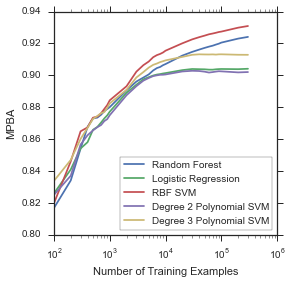

In [8]:
fig = plt.figure(figsize=(4, 4))
ax = plot_average_learning_curve(sample_sizes, all_learning_curves, curve_labels)
ax.set_xscale('log')
fig.savefig(fig_dir + '4_expt1/sdss_learning_curves.pdf', bbox_inches='tight')

Upper bounds for Logistic Regression and RBF SVM

In [15]:
logistic_lc = np.array(all_learning_curves[1])
rbf_lc = np.array(all_learning_curves[2])
print(np.mean(logistic_lc[:,-1]))
print(np.mean(rbf_lc[:,-1]))

0.898435180803
0.930910538547


### VST ATLAS Learning Curves

In [5]:
X = np.asarray(vstatlas[vstatlas_features])
y = np.asarray(vstatlas[target_col])
cv = StratifiedShuffleSplit(y, n_iter=5, test_size=0.3, train_size=0.7, random_state=29)

In [9]:
rbf = SVC(kernel='rbf', gamma=0.001, C=1000000, cache_size=2000, class_weight='auto')
poly = LinearSVC(C=1000, multi_class='crammer_singer',
                     fit_intercept=True, class_weight='auto', random_state=21)
logistic = LogisticRegression(penalty='l1', dual=False, C=100, multi_class='ovr', solver='liblinear', class_weight='auto', random_state=21)
forest = RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='subsample', random_state=21)
classifiers = [forest, logistic, rbf, poly]
degrees = [1, 2, 1, 1]

In [10]:
sample_sizes = np.concatenate((np.arange(100, 1000, 100), np.arange(1000, 10000, 1000),
                               np.arange(10000, 30001, 10000), [35056]))
curve_labels = ['Random Forest', 'Logistic Regression', 'RBF SVM', 'Linear SVM']
pickle_paths = ['../pickle/04_learning_curves/vstatlas_lc_forest.pickle',
                '../pickle/04_learning_curves/vstatlas_lc_logistic.pickle',
                '../pickle/04_learning_curves/vstatlas_lc_rbf.pickle',
                '../pickle/04_learning_curves/vstatlas_lc_poly.pickle']

for classifier, degree, pickle_path in zip(classifiers, degrees, pickle_paths):
    if not results_exist(pickle_path):
        learning_curve(classifier, X, y, cv, sample_sizes, degree, pickle_path)
all_learning_curves = load_results(pickle_paths)

In [11]:
for c in all_learning_curves:
    print(np.array(c)[:, -1])

[ 0.9798853   0.98785785  0.98537427  0.98455806  0.9846886 ]
[ 0.96188746  0.97918682  0.9773806   0.96799062  0.9691141 ]
[ 0.9894657   0.99068722  0.98983486  0.99091814  0.98807382]
[ 0.96247019  0.96764482  0.96677388  0.94743558  0.93264851]


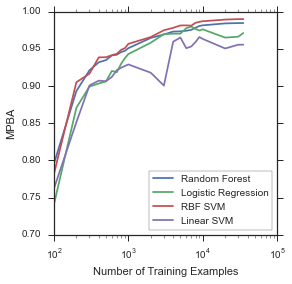

In [12]:
fig = plt.figure(figsize=(4, 4))
ax = plot_average_learning_curve(sample_sizes, all_learning_curves, curve_labels)
ax.set_xscale('log')
fig.savefig(fig_dir + '4_expt1/vstatlas_learning_curves.pdf', bbox_inches='tight')

In [13]:
logistic_lc = np.array(all_learning_curves[1])
rbf_lc = np.array(all_learning_curves[2])
print(np.max(logistic_lc[:,-1]))
print(np.max(rbf_lc[:,-1]))

0.979186822939
0.990918135306


## Appendix: Time Complexity

In [35]:
transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
X_poly = transformer.fit_transform(X)

In [7]:
%%timeit -n 1 -r 1
rbf = SVC(kernel='rbf', gamma=0.001, C=1000, cache_size=2000, class_weight='auto', probability=True)
rbf.fit(X, y)

1 loops, best of 1: 2min 11s per loop


In [34]:
%%timeit -n 1 -r 1
rbf = SVC(kernel='rbf', gamma=0.1, C=10, cache_size=2000, class_weight='auto', probability=True)
rbf.fit(X, y)

1 loops, best of 1: 17.2 s per loop


In [36]:
%%timeit -n 1 -r 1
poly = LinearSVC(C=1000, multi_class='crammer_singer',
                     fit_intercept=True, class_weight='auto', random_state=21)
poly.fit(X, y)

1 loops, best of 1: 11.1 s per loop


In [38]:
%%timeit -n 1 -r 1
poly = LinearSVC(C=0.1, loss='squared_hinge', penalty='l1', dual=False, multi_class='ovr',
                     fit_intercept=True, class_weight='auto', random_state=21)
poly.fit(X_poly, y)

1 loops, best of 1: 22 s per loop


In [ ]:
%%timeit -n 1 -r 1
logistic = LogisticRegression(penalty='l1', dual=False, C=100, multi_class='ovr', solver='liblinear', random_state=21)
logistic.fit(X_poly, y)